In [1]:
# Cell 1: Clone from GitHub
!git clone https://github.com/vishnu2505/nyc_payroll_analysis.git
%cd nyc_payroll_analysis

import sys
sys.path.insert(0, '/content/nyc_payroll_analysis')

print(" Repository cloned!")

Cloning into 'nyc_payroll_analysis'...
remote: Enumerating objects: 27, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 27 (delta 12), reused 23 (delta 8), pack-reused 0 (from 0)
Receiving objects: 100% (27/27), 18.20 KiB | 18.20 MiB/s, done.
Resolving deltas: 100% (12/12), done.
/content/nyc_payroll_analysis
 Repository cloned!


In [2]:
import config as config
import data_processing as dp
import model_training as mt
import visualization as viz

# Standard imports
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Create output directories if they don't exist
import os
os.makedirs(config.OUTPUT_DIR, exist_ok=True)
os.makedirs(config.MODELS_DIR, exist_ok=True)
os.makedirs(config.PLOTS_DIR, exist_ok=True)

print("All modules imported successfully")
print(f"Project: {config.PROJECT_NAME}")
print(f"Authors: {', '.join(config.AUTHORS)}")

All modules imported successfully
Project: NYC Municipal Payroll Analysis
Authors: Vishnu S, Sharan Venkatesh


In [3]:
# Initialize Spark
spark = dp.initialize_spark("NYC_Payroll_ML_Analysis")

✓ Spark 4.0.1 initialized successfully


In [4]:
# Execute complete data processing pipeline
df_clean = dp.full_data_pipeline(
    spark=spark,
    file_path=config.DATA_PATH,
    years=config.FISCAL_YEARS
)


EXECUTING FULL DATA PROCESSING PIPELINE

Loading data from: /content/nyc_payroll_FINAL_FOR_TABLEAU.csv
✓ Loaded 1,014,490 records with 19 columns
✓ Filtered to fiscal years [2023, 2024, 2025]: 1,014,490 records

Records by Fiscal Year:
+-----------+------+
|Fiscal Year| count|
+-----------+------+
|       2023|338552|
|       2024|345649|
|       2025|330289|
+-----------+------+

✓ Cleaning currency columns...
✓ Calculating Years of Service (reference: 2025-06-30)
✓ Creating derived features...
✓ Removed 690 invalid records (0.07%)
✓ Clean dataset: 1,013,800 records

DATASET SUMMARY STATISTICS

Numerical Columns:
+-------+-----------------+------------------+------------------+-----------------+
|summary|      Base Salary|  Years of Service|          OT Hours|    Total OT Paid|
+-------+-----------------+------------------+------------------+-----------------+
|  count|          1013800|           1013800|           1013800|          1013800|
|   mean|87829.80159227658|13.90333979179

In [5]:
# Prepare features for salary prediction
df_model1 = dp.prepare_model1_features(df_clean)

# Convert to Pandas for XGBoost
df_model1_pd = df_model1.toPandas()
print(f" Converted to Pandas: {len(df_model1_pd):,} rows")

✓ Model 1 features prepared: 1,013,753 samples
 Converted to Pandas: 1,013,753 rows


In [6]:
# Reduce cardinality of categorical variables
df_model1_pd, top_agencies, top_titles = dp.reduce_cardinality(
    df_model1_pd,
    top_n_agencies=config.TOP_N_AGENCIES,
    top_n_titles=config.TOP_N_TITLES
)

✓ Reduced cardinality: Top 15 agencies, Top 30 titles


In [7]:
# Encode features
X1, y1 = dp.encode_features(
    df_model1_pd,
    target_col='Base Salary',
    exclude_cols=[]
)

print(f"\nFeature Matrix Shape: {X1.shape}")
print(f"Target Variable Shape: {y1.shape}")
print(f"\nFirst 10 Features: {list(X1.columns[:10])}")

✓ Encoded features: 73 features, 1013753 samples
  - Numerical features: 7
  - Categorical features: 5

Feature Matrix Shape: (1013753, 73)
Target Variable Shape: (1013753,)

First 10 Features: ['Fiscal Year', 'Years of Service', 'Years_Squared', 'Years_Cubed', 'Seniority_Tier', 'Service_Decade', 'Is_Senior', 'Agency Name_DEPARTMENT OF CORRECTION', 'Agency Name_DEPARTMENT OF EDUCATION ADMIN', 'Agency Name_DEPARTMENT OF SANITATION']


In [8]:
# Split data
X1_train, X1_test, y1_train, y1_test = mt.split_data(X1, y1)

 Data split: 811,002 train, 202,751 test


In [9]:
# Train and evaluate complete pipeline for Model 1
model1, metrics1, importance1 = mt.train_and_evaluate_salary_model(
    X1_train, X1_test, y1_train, y1_test
)


MODEL 1: SALARY PREDICTION PIPELINE

TRAINING XGBOOST REGRESSOR
Configuration: {'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 0.6, 'min_child_weight': 3, 'gamma': 0.1, 'reg_alpha': 0.1, 'reg_lambda': 1.0, 'random_state': 42, 'n_jobs': -1}

 Training in progress...
 Training complete!

REGRESSION MODEL EVALUATION

 Performance Metrics:
  Training R²:     0.6494
  Test R²:         0.6495
  Test RMSE:       $21,080.88
  Test MAE:        $12,423.76

 Interpretation:
  • Model explains 64.95% of salary variance
  • Average prediction error: $12,424
  Good generalization (gap: -0.01%)

 Sample Predictions:
  Actual     Predicted         Error    Error_%
 92585.0  92550.109375     34.890625   0.037685
 33165.0  41204.175781  -8039.175781  24.239939
153641.0 116985.578125  36655.421875  23.857838
 97939.0 143532.578125 -45593.578125  46.553036
110168.0 104487.187500   5680.812500   5.156499
 47136.0  95625.968750 -48489.968750 102.872467
129


GENERATING MODEL 1 VISUALIZATIONS
✓ Plot saved: plots/model1_feature_importance.png


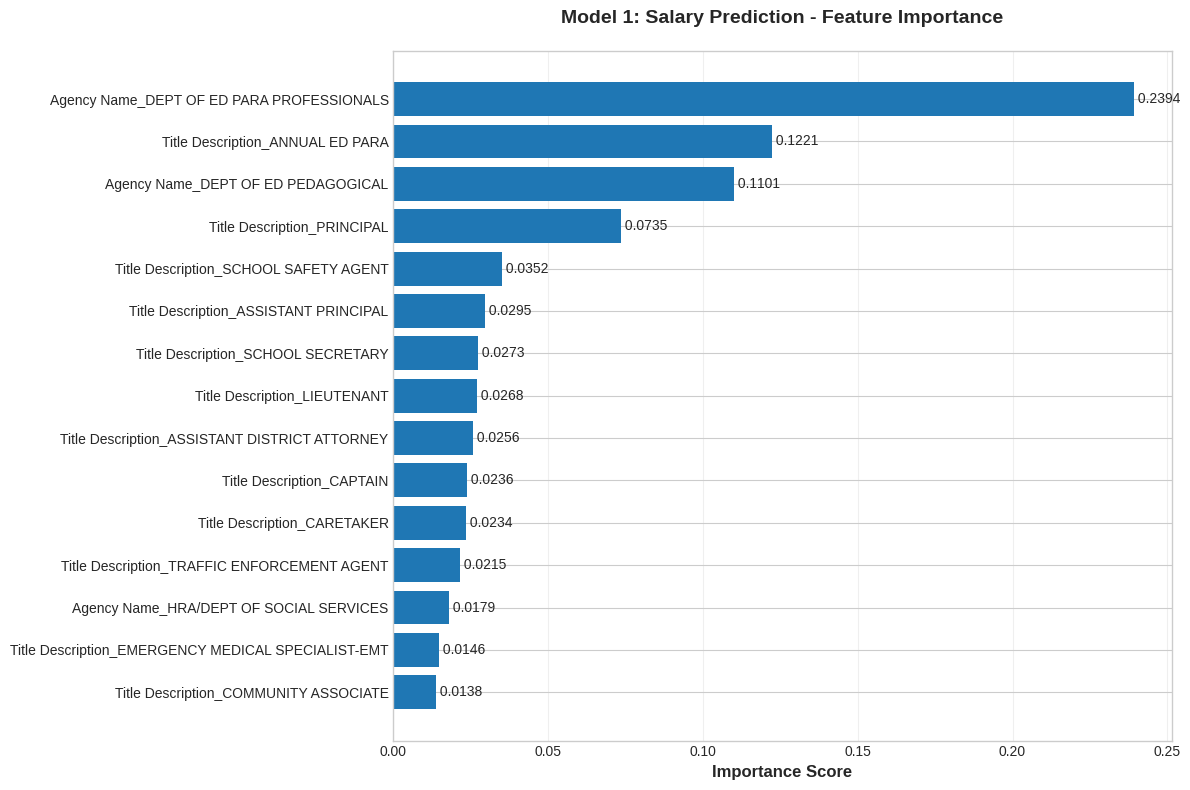

✓ Plot saved: plots/model1_actual_vs_predicted.png


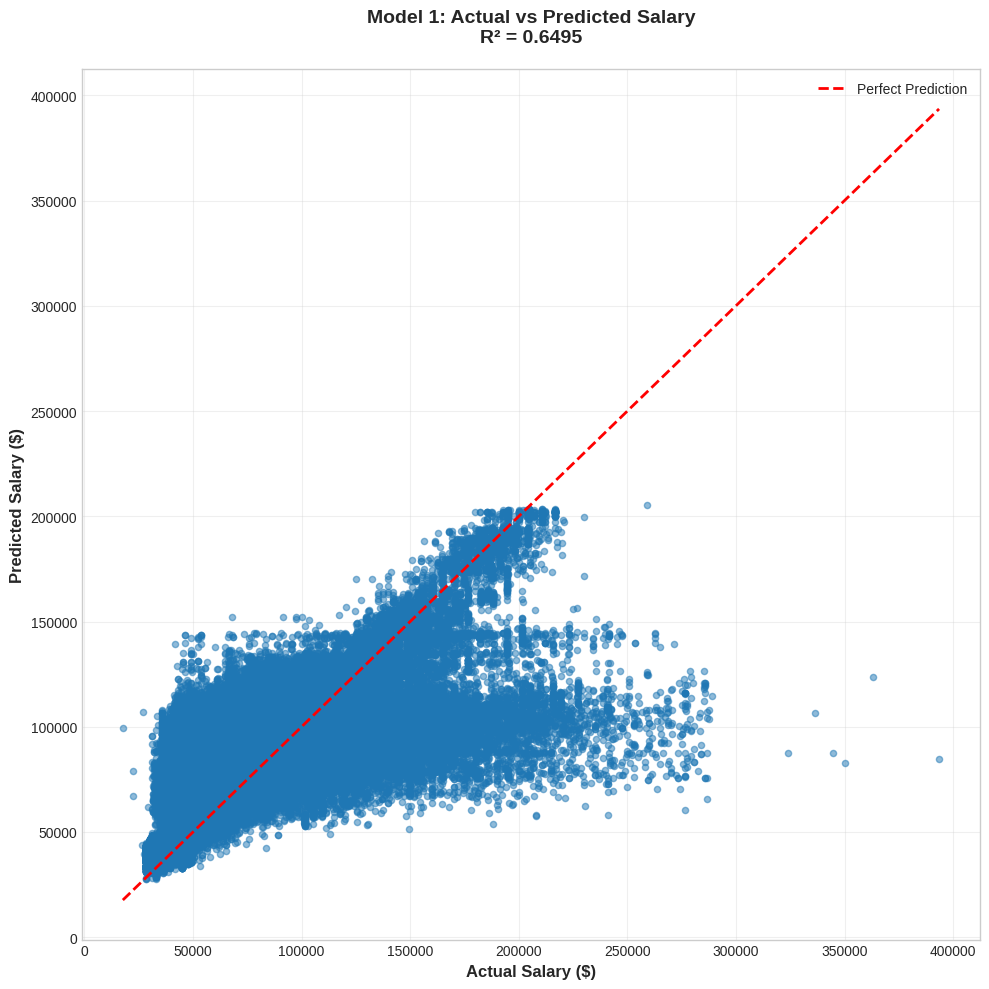

✓ Plot saved: plots/model1_residuals.png


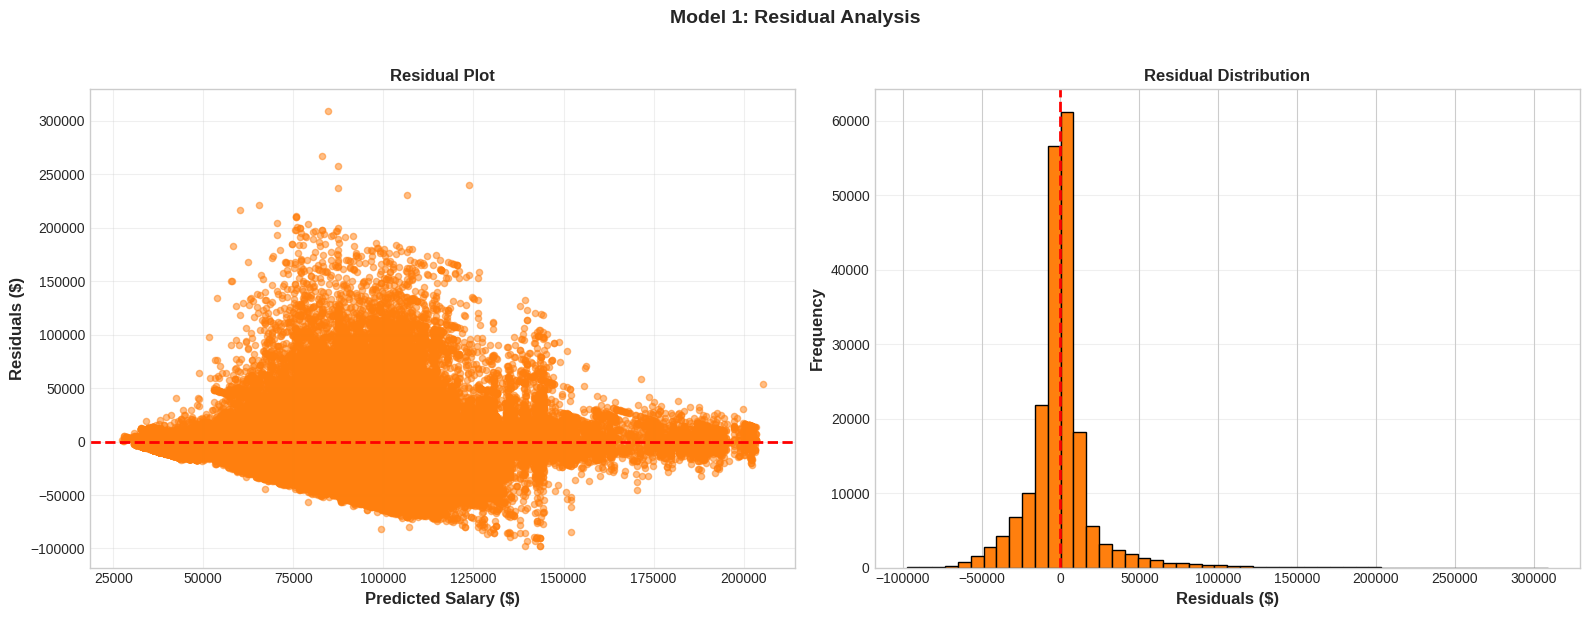

Model 1 visualizations complete!


In [10]:
# Generate all visualizations for Model 1
viz.create_model1_visualizations(
    model=model1,
    X_test=X1_test,
    y_test=y1_test,
    importance_df=importance1,
    save_dir=config.PLOTS_DIR
)

In [11]:
print("\n" + "="*80)
print("MODEL 1 SUMMARY: SALARY PREDICTION")
print("="*80)
print(f"\n Business Question Answered:")
print("   How do tenure, geography, and agency affect base salary?\n")

print(f" Performance Metrics:")
for metric, value in metrics1.items():
    if 'r2' in metric:
        print(f"   {metric}: {value:.4f} ({value*100:.2f}%)")
    else:
        print(f"   {metric}: ${value:,.2f}")

print(f"\n Top 5 Features:")
for idx, row in importance1.head(5).iterrows():
    print(f"   {row['Feature'][:45]:45s} : {row['Importance']:.4f}")

print(f"\n Outputs Generated:")
print(f"    Model saved: {config.XGBOOST_MODEL_PATH}")
print(f"    Predictions: {config.OUTPUT_DIR}{config.SALARY_PREDICTIONS_FILE}")
print(f"    Feature Importance: {config.OUTPUT_DIR}{config.SALARY_FEATURE_IMPORTANCE_FILE}")


MODEL 1 SUMMARY: SALARY PREDICTION

 Business Question Answered:
   How do tenure, geography, and agency affect base salary?

 Performance Metrics:
   train_r2: 0.6494 (64.94%)
   test_r2: 0.6495 (64.95%)
   test_rmse: $21,080.88
   test_mae: $12,423.76

 Top 5 Features:
   Agency Name_DEPT OF ED PARA PROFESSIONALS     : 0.2394
   Title Description_ANNUAL ED PARA              : 0.1221
   Agency Name_DEPT OF ED PEDAGOGICAL            : 0.1101
   Title Description_PRINCIPAL                   : 0.0735
   Title Description_SCHOOL SAFETY AGENT         : 0.0352

 Outputs Generated:
    Model saved: models/xgboost_salary_model.pkl
    Predictions: output/salary_predictions.csv
    Feature Importance: output/salary_feature_importance.csv


In [12]:
# Prepare features for overtime risk classification
df_model2 = dp.prepare_model2_features(df_clean)

# Convert to Pandas
df_model2_pd = df_model2.toPandas()
print(f"Converted to Pandas: {len(df_model2_pd):,} rows")

✓ Model 2 features prepared: 1,013,753 samples

Overtime Risk Distribution:
+-------+------+
|At_Risk| count|
+-------+------+
|      1| 47119|
|      0|966634|
+-------+------+

Converted to Pandas: 1,013,753 rows


In [13]:
# Reduce cardinality (reuse top agencies and titles from Model 1)
df_model2_pd['Agency Name'] = df_model2_pd['Agency Name'].apply(
    lambda x: x if x in top_agencies else 'OTHER'
)
df_model2_pd['Title Description'] = df_model2_pd['Title Description'].apply(
    lambda x: x if x in top_titles else 'OTHER'
)

print(" Cardinality reduced using Model 1 categories")

 Cardinality reduced using Model 1 categories


In [14]:
# Encode features (exclude OT-related columns to prevent data leakage)
X2, y2 = dp.encode_features(
    df_model2_pd,
    target_col='At_Risk',
    exclude_cols=['OT Hours', 'Total OT Paid', 'OT_Risk_Category']
)

print(f"\nFeature Matrix Shape: {X2.shape}")
print(f"Target Variable Shape: {y2.shape}")
print(f"\nClass Distribution:\n{y2.value_counts()}")

✓ Encoded features: 66 features, 1013753 samples
  - Numerical features: 3
  - Categorical features: 3

Feature Matrix Shape: (1013753, 66)
Target Variable Shape: (1013753,)

Class Distribution:
At_Risk
0    966634
1     47119
Name: count, dtype: int64


In [15]:
# Split data with stratification for imbalanced classes
X2_train, X2_test, y2_train, y2_test = mt.split_data(X2, y2, stratify=y2)

 Data split: 811,002 train, 202,751 test


In [16]:
# Train and evaluate complete pipeline for Model 2
model2, metrics2, importance2 = mt.train_and_evaluate_risk_model(
    X2_train, X2_test, y2_train, y2_test
)


MODEL 2: OVERTIME RISK CLASSIFICATION PIPELINE

TRAINING RANDOM FOREST CLASSIFIER
Configuration: {'n_estimators': 200, 'max_depth': 15, 'min_samples_split': 10, 'min_samples_leaf': 5, 'class_weight': 'balanced', 'random_state': 42, 'n_jobs': -1}

 Training in progress...
 Training complete!

CLASSIFICATION MODEL EVALUATION

 Performance Metrics:
  Training Accuracy:   0.8059
  Test Accuracy:       0.8037
  Precision:           0.1775
  Recall:              0.8869
  F1 Score:            0.2958

 Confusion Matrix:
                     Predicted Not At Risk | Predicted At Risk
  Actual Not At Risk:     154,596         |    38,731
  Actual At Risk:           1,066         |     8,358

 Detailed Classification Report:
              precision    recall  f1-score   support

 Not At Risk     0.9932    0.7997    0.8860    193327
     At Risk     0.1775    0.8869    0.2958      9424

    accuracy                         0.8037    202751
   macro avg     0.5853    0.8433    0.5909    202751
weig


GENERATING MODEL 2 VISUALIZATIONS
✓ Plot saved: plots/model2_feature_importance.png


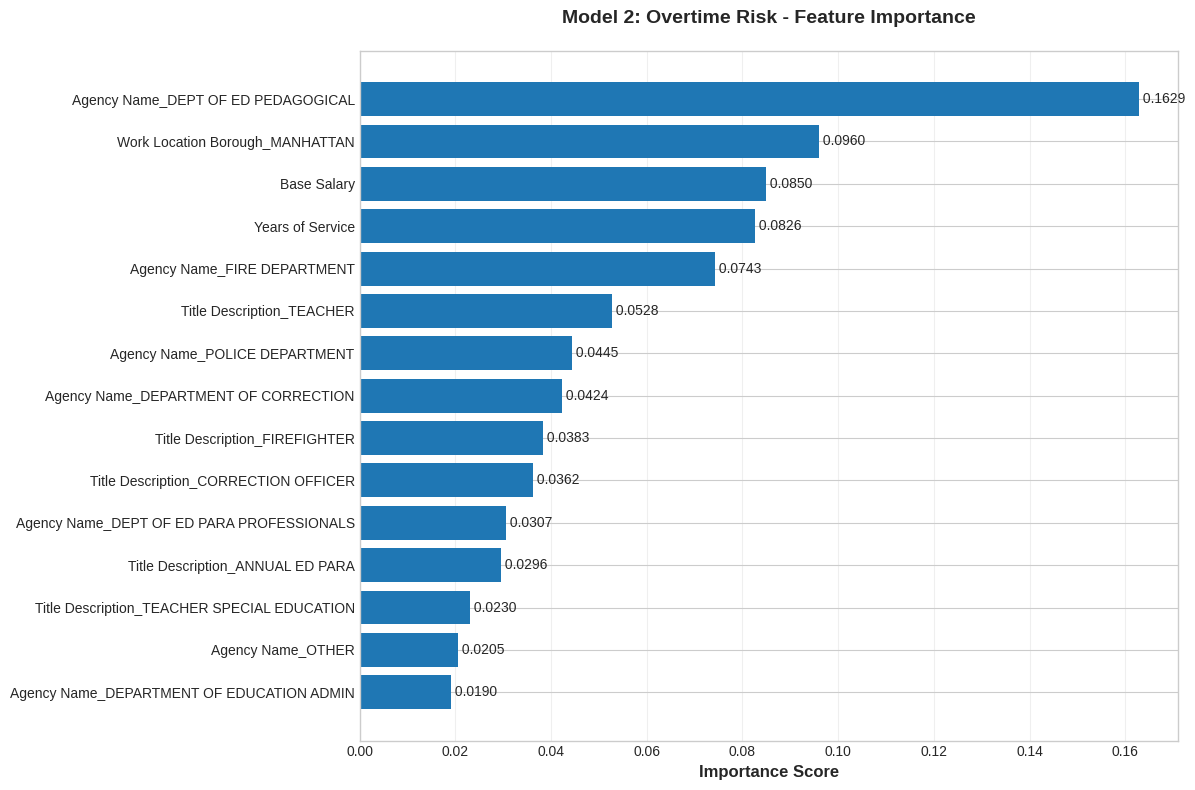

✓ Plot saved: plots/model2_confusion_matrix.png


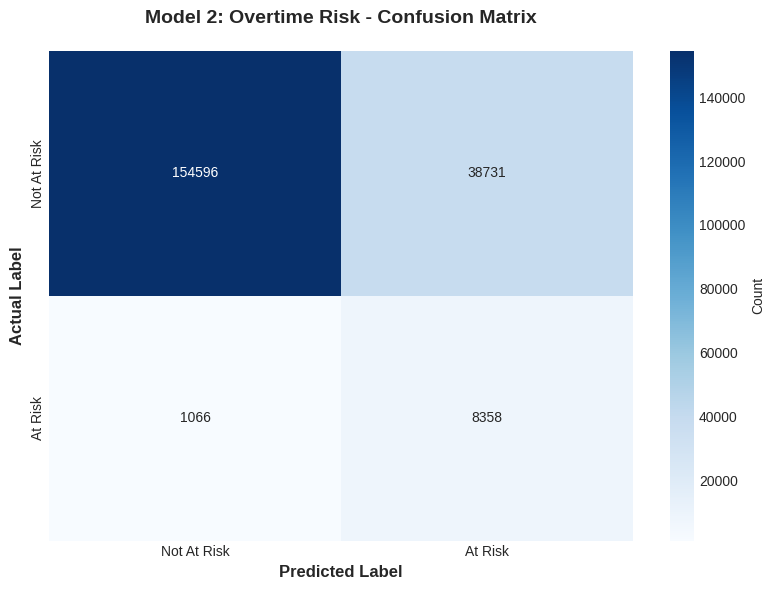

✓ Plot saved: plots/model2_roc_curve.png


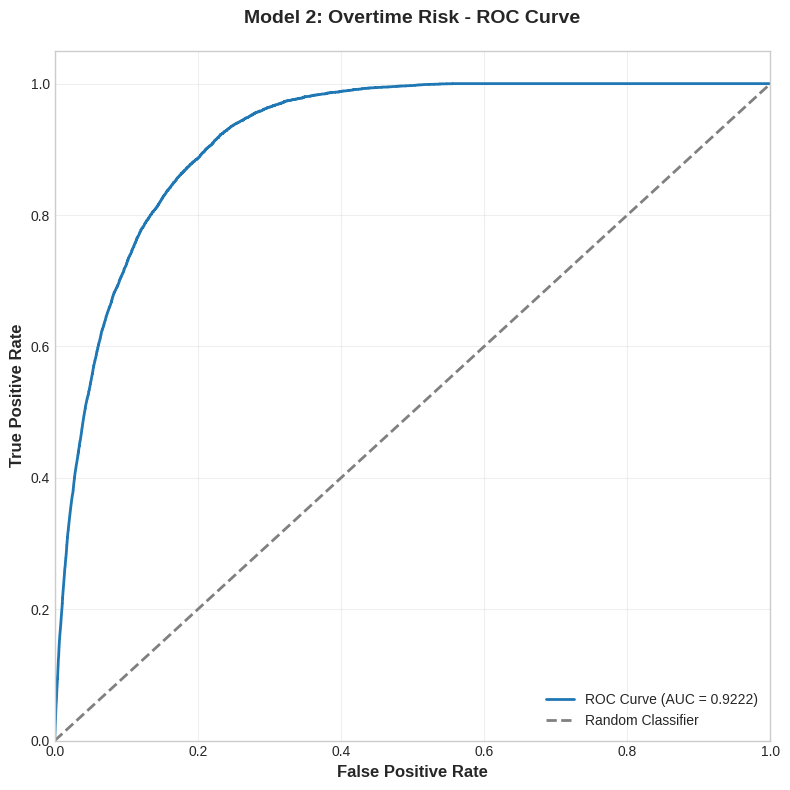

Model 2 visualizations complete!


In [17]:
# Generate all visualizations for Model 2
viz.create_model2_visualizations(
    model=model2,
    X_test=X2_test,
    y_test=y2_test,
    importance_df=importance2,
    save_dir=config.PLOTS_DIR
)

In [18]:
print("\n" + "="*80)
print("MODEL 2 SUMMARY: OVERTIME RISK CLASSIFICATION")
print("="*80)
print(f"\n Business Question Answered:")
print("   Which employees are at high risk of overtime burnout?\n")

print(f" Performance Metrics:")
for metric, value in metrics2.items():
    print(f"   {metric}: {value:.4f}")

print(f"\n Top 5 Risk Factors:")
for idx, row in importance2.head(5).iterrows():
    print(f"   {row['Feature'][:45]:45s} : {row['Importance']:.4f}")

print(f"\n Outputs Generated:")
print(f"    Model saved: {config.RF_MODEL_PATH}")
print(f"    Predictions: {config.OUTPUT_DIR}{config.RISK_PREDICTIONS_FILE}")
print(f"    Feature Importance: {config.OUTPUT_DIR}{config.RISK_FEATURE_IMPORTANCE_FILE}")


MODEL 2 SUMMARY: OVERTIME RISK CLASSIFICATION

 Business Question Answered:
   Which employees are at high risk of overtime burnout?

 Performance Metrics:
   train_accuracy: 0.8059
   test_accuracy: 0.8037
   precision: 0.1775
   recall: 0.8869
   f1: 0.2958

 Top 5 Risk Factors:
   Agency Name_DEPT OF ED PEDAGOGICAL            : 0.1629
   Work Location Borough_MANHATTAN               : 0.0960
   Base Salary                                   : 0.0850
   Years of Service                              : 0.0826
   Agency Name_FIRE DEPARTMENT                   : 0.0743

 Outputs Generated:
    Model saved: models/random_forest_risk_model.pkl
    Predictions: output/overtime_risk_predictions.csv
    Feature Importance: output/risk_feature_importance.csv


In [19]:
print("\n" + "="*80)
print("FINAL BUSINESS INSIGHTS - ANSWERING KEY QUESTIONS")
print("="*80)

print("\n QUESTION 1: How do tenure and geography affect salary?")
print("-" * 80)

# Calculate importance by category
tenure_imp = importance1[importance1['Feature'] == 'Years of Service']['Importance'].sum()
borough_imp = importance1[importance1['Feature'].str.contains('Borough', na=False)]['Importance'].sum()
agency_imp = importance1[importance1['Feature'].str.contains('Agency', na=False)]['Importance'].sum()

print(f"\n TENURE Impact: {tenure_imp*100:.1f}%")
print(f"   Years of service is {'THE STRONGEST' if tenure_imp > 0.2 else 'a SIGNIFICANT'} predictor")
print(f"   Each additional year contributes to salary determination")

print(f"\n GEOGRAPHY Impact: {borough_imp*100:.1f}%")
print(f"   Borough location affects {borough_imp*100:.1f}% of salary variance")
print(f"   {'Significant' if borough_imp > 0.05 else 'Moderate'} geographic salary differences exist")

print(f"\n AGENCY Impact: {agency_imp*100:.1f}%")
print(f"   Agency affiliation explains {agency_imp*100:.1f}% of variance")

print(f"\n MODEL PERFORMANCE: R² = {metrics1['test_r2']:.4f}")
print(f"   Can predict salary with average error of ${metrics1['test_mae']:,.0f}")
print(f"   Model explains {metrics1['test_r2']*100:.1f}% of all salary variation")


FINAL BUSINESS INSIGHTS - ANSWERING KEY QUESTIONS

 QUESTION 1: How do tenure and geography affect salary?
--------------------------------------------------------------------------------

 TENURE Impact: 0.5%
   Years of service is a SIGNIFICANT predictor
   Each additional year contributes to salary determination

 GEOGRAPHY Impact: 0.8%
   Borough location affects 0.8% of salary variance
   Moderate geographic salary differences exist

 AGENCY Impact: 40.9%
   Agency affiliation explains 40.9% of variance

 MODEL PERFORMANCE: R² = 0.6495
   Can predict salary with average error of $12,424
   Model explains 64.9% of all salary variation


In [20]:
print("\n" + "="*80)
print(" QUESTION 2: Who is at overtime burnout risk?")
print("-" * 80)

print(f"\n MODEL ACCURACY: {metrics2['test_accuracy']*100:.1f}%")
print(f"   Correctly identifies overtime risk with {metrics2['test_accuracy']*100:.1f}% accuracy")

print(f"\n RECALL: {metrics2['recall']*100:.1f}%")
print(f"   Detects {metrics2['recall']*100:.1f}% of actual high-risk employees")
print(f"   {'Good performance' if metrics2['recall'] >= config.MIN_ACCEPTABLE_RECALL else 'Warning: May miss some at-risk employees'}")

print(f"\n PRECISION: {metrics2['precision']*100:.1f}%")
print(f"   When flagged, {metrics2['precision']*100:.1f}% are truly at risk")
print(f"   Minimizes false alarms for HR intervention")

# Top risk factors
print(f"\n TOP RISK FACTORS:")
for idx, row in importance2.head(3).iterrows():
    feature = row['Feature']
    if 'Agency' in feature:
        print(f"   {feature}: Certain agencies have higher OT dependency")
    elif 'Title' in feature:
        print(f"   {feature}: Job role strongly predicts overtime risk")
    elif 'Salary' in feature:
        print(f"   {feature}: Salary level correlates with OT patterns")
    else:
        print(f"   {feature}: Contributes {row['Importance']*100:.1f}% to risk")


 QUESTION 2: Who is at overtime burnout risk?
--------------------------------------------------------------------------------

 MODEL ACCURACY: 80.4%
   Correctly identifies overtime risk with 80.4% accuracy

 RECALL: 88.7%
   Detects 88.7% of actual high-risk employees
   Good performance

 PRECISION: 17.7%
   When flagged, 17.7% are truly at risk
   Minimizes false alarms for HR intervention

 TOP RISK FACTORS:
   Agency Name_DEPT OF ED PEDAGOGICAL: Certain agencies have higher OT dependency
   Work Location Borough_MANHATTAN: Contributes 9.6% to risk
   Base Salary: Salary level correlates with OT patterns


In [21]:
print("\n" + "="*80)
print(" ACTIONABLE RECOMMENDATIONS")
print("-" * 80)
print("\n1. SALARY EQUITY AUDIT")
print(f"    Use Model 1 predictions to identify employees earning ${metrics1['test_mae']*2:,.0f}+ below expected")
print("    Review geographic pay disparities across boroughs")
print("    Investigate tenure-salary relationship for fair compensation")

print("\n2. OVERTIME RISK MANAGEMENT")
print(f"    Deploy Model 2 quarterly to identify high-risk employees")
print(f"    Focus on {importance2.head(1)['Feature'].values[0]} as primary intervention point")
print("    Proactive wellness programs for flagged employees")

print("\n3. STRATEGIC WORKFORCE PLANNING")
print("    Forecast salary budgets using Model 1 for headcount planning")
print("    Redistribute workload in high-OT agencies identified by Model 2")
print("    Target recruitment in understaffed departments")




 ACTIONABLE RECOMMENDATIONS
--------------------------------------------------------------------------------

1. SALARY EQUITY AUDIT
    Use Model 1 predictions to identify employees earning $24,848+ below expected
    Review geographic pay disparities across boroughs
    Investigate tenure-salary relationship for fair compensation

2. OVERTIME RISK MANAGEMENT
    Deploy Model 2 quarterly to identify high-risk employees
    Focus on Agency Name_DEPT OF ED PEDAGOGICAL as primary intervention point
    Proactive wellness programs for flagged employees

3. STRATEGIC WORKFORCE PLANNING
    Forecast salary budgets using Model 1 for headcount planning
    Redistribute workload in high-OT agencies identified by Model 2
    Target recruitment in understaffed departments
